# カテゴリ値を含むデータでのLightGBMを使った分析

### データ
[Adult Data Set](https://archive.ics.uci.edu/ml/datasets/adult) \
[Adult income dataset](https://www.kaggle.com/wenruliu/adult-income-dataset/version/2)

### 参考
[lightgbmで二値分類の一連の流れをしたメモ](https://qiita.com/d_desuyon/items/807e01311ad08570ee78) \
[【初心者向け】特徴量重要度の算出 (LightGBM) 【Python】【機械学習】](https://mathmatical22.xyz/2020/04/12/%E3%80%90%E5%88%9D%E5%BF%83%E8%80%85%E5%90%91%E3%81%91%E3%80%91%E7%89%B9%E5%BE%B4%E9%87%8F%E9%87%8D%E8%A6%81%E5%BA%A6%E3%81%AE%E7%AE%97%E5%87%BA-lightgbm-%E3%80%90python%E3%80%91%E3%80%90%E6%A9%9F/) \
[LightGBMのCategorical Featureによって精度が向上するか？](https://qiita.com/sinchir0/items/b038757e578b790ec96a)

In [1]:
!python -V

Python 3.8.8


In [2]:
!python -m pip --version

pip 21.3.1 from /opt/conda/lib/python3.8/site-packages/pip (python 3.8)


In [3]:
!python -m pip list

Package                       Version
----------------------------- -------------------
alembic                       1.6.0
anyio                         2.2.0
argon2-cffi                   20.1.0
async-generator               1.10
attrs                         20.3.0
autopage                      0.5.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
bleach                        3.3.0
blinker                       1.4
brotlipy                      0.7.0
certifi                       2020.12.5
certipy                       0.1.3
cffi                          1.14.5
chardet                       4.0.0
cliff                         3.10.0
cloudpickle                   2.0.0
cmaes                         0.8.2
cmd2                          2.3.3
colorlog                      6.6.0
conda                         4.10.0
conda-package-handling        1.7.3
cryptography                  3.4.7
cycler                        0.11.0
decor

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, auc, roc_curve, precision_score, confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
df = pd.read_csv('adult_cat2num.csv')

In [6]:
df.head(10)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,3,226802,1,7,4,6,3,2,1,0,0,40,38,0
1,38,3,89814,11,9,2,4,0,4,1,0,0,50,38,0
2,28,1,336951,7,12,2,10,0,4,1,0,0,40,38,1
3,44,3,160323,15,10,2,6,0,2,1,7688,0,40,38,1
4,34,3,198693,0,6,4,7,1,4,1,0,0,30,38,0
5,63,5,104626,14,15,2,9,0,4,1,3103,0,32,38,1
6,24,3,369667,15,10,4,7,4,4,0,0,0,40,38,0
7,55,3,104996,5,4,2,2,0,4,1,0,0,10,38,0
8,65,3,184454,11,9,2,6,0,4,1,6418,0,40,38,1
9,36,0,212465,9,13,2,0,0,4,1,0,0,40,38,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   age              45222 non-null  int64
 1   workclass        45222 non-null  int64
 2   fnlwgt           45222 non-null  int64
 3   education        45222 non-null  int64
 4   educational-num  45222 non-null  int64
 5   marital-status   45222 non-null  int64
 6   occupation       45222 non-null  int64
 7   relationship     45222 non-null  int64
 8   race             45222 non-null  int64
 9   gender           45222 non-null  int64
 10  capital-gain     45222 non-null  int64
 11  capital-loss     45222 non-null  int64
 12  hours-per-week   45222 non-null  int64
 13  native-country   45222 non-null  int64
 14  income           45222 non-null  int64
dtypes: int64(15)
memory usage: 5.2 MB


In [8]:
columns_cat = [
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'gender',
    'native-country',
    #'income',
]

In [9]:
{cat:'category' for cat in columns_cat}

{'workclass': 'category',
 'education': 'category',
 'marital-status': 'category',
 'occupation': 'category',
 'relationship': 'category',
 'race': 'category',
 'gender': 'category',
 'native-country': 'category'}

In [10]:
df = df.astype({cat:'category' for cat in columns_cat})

In [11]:
for cat in columns_cat:
    print(cat, df[cat].cat.categories)

workclass Int64Index([0, 1, 3, 4, 5, 6, 7], dtype='int64')
education Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], dtype='int64')
marital-status Int64Index([0, 1, 2, 3, 4, 5, 6], dtype='int64')
occupation Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], dtype='int64')
relationship Int64Index([0, 1, 2, 3, 4, 5], dtype='int64')
race Int64Index([0, 1, 2, 3, 4], dtype='int64')
gender Int64Index([0, 1], dtype='int64')
native-country Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40],
           dtype='int64')


In [12]:
df['income'].value_counts()

0    34014
1    11208
Name: income, dtype: int64

In [13]:
df.head(10)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,3,226802,1,7,4,6,3,2,1,0,0,40,38,0
1,38,3,89814,11,9,2,4,0,4,1,0,0,50,38,0
2,28,1,336951,7,12,2,10,0,4,1,0,0,40,38,1
3,44,3,160323,15,10,2,6,0,2,1,7688,0,40,38,1
4,34,3,198693,0,6,4,7,1,4,1,0,0,30,38,0
5,63,5,104626,14,15,2,9,0,4,1,3103,0,32,38,1
6,24,3,369667,15,10,4,7,4,4,0,0,0,40,38,0
7,55,3,104996,5,4,2,2,0,4,1,0,0,10,38,0
8,65,3,184454,11,9,2,6,0,4,1,6418,0,40,38,1
9,36,0,212465,9,13,2,0,0,4,1,0,0,40,38,0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   age              45222 non-null  int64   
 1   workclass        45222 non-null  category
 2   fnlwgt           45222 non-null  int64   
 3   education        45222 non-null  category
 4   educational-num  45222 non-null  int64   
 5   marital-status   45222 non-null  category
 6   occupation       45222 non-null  category
 7   relationship     45222 non-null  category
 8   race             45222 non-null  category
 9   gender           45222 non-null  category
 10  capital-gain     45222 non-null  int64   
 11  capital-loss     45222 non-null  int64   
 12  hours-per-week   45222 non-null  int64   
 13  native-country   45222 non-null  category
 14  income           45222 non-null  int64   
dtypes: category(8), int64(7)
memory usage: 2.8 MB


In [15]:
df.isnull().sum(axis=0)

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

In [16]:
df = df.dropna(axis=0)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   age              45222 non-null  int64   
 1   workclass        45222 non-null  category
 2   fnlwgt           45222 non-null  int64   
 3   education        45222 non-null  category
 4   educational-num  45222 non-null  int64   
 5   marital-status   45222 non-null  category
 6   occupation       45222 non-null  category
 7   relationship     45222 non-null  category
 8   race             45222 non-null  category
 9   gender           45222 non-null  category
 10  capital-gain     45222 non-null  int64   
 11  capital-loss     45222 non-null  int64   
 12  hours-per-week   45222 non-null  int64   
 13  native-country   45222 non-null  category
 14  income           45222 non-null  int64   
dtypes: category(8), int64(7)
memory usage: 2.8 MB


In [18]:
df.head(10)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,3,226802,1,7,4,6,3,2,1,0,0,40,38,0
1,38,3,89814,11,9,2,4,0,4,1,0,0,50,38,0
2,28,1,336951,7,12,2,10,0,4,1,0,0,40,38,1
3,44,3,160323,15,10,2,6,0,2,1,7688,0,40,38,1
4,34,3,198693,0,6,4,7,1,4,1,0,0,30,38,0
5,63,5,104626,14,15,2,9,0,4,1,3103,0,32,38,1
6,24,3,369667,15,10,4,7,4,4,0,0,0,40,38,0
7,55,3,104996,5,4,2,2,0,4,1,0,0,10,38,0
8,65,3,184454,11,9,2,6,0,4,1,6418,0,40,38,1
9,36,0,212465,9,13,2,0,0,4,1,0,0,40,38,0


In [19]:
# 不要カラムの削除と並べ替え
df = df[["age",
         "workclass",
         #"fnlwgt",
         "education",
         "educational-num",
         "marital-status",
         "occupation",
         "relationship",
         "race",
         "gender",
         "capital-gain",
         "capital-loss",
         "hours-per-week",
         "native-country",
         "income",]]
df.head(10)

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,3,1,7,4,6,3,2,1,0,0,40,38,0
1,38,3,11,9,2,4,0,4,1,0,0,50,38,0
2,28,1,7,12,2,10,0,4,1,0,0,40,38,1
3,44,3,15,10,2,6,0,2,1,7688,0,40,38,1
4,34,3,0,6,4,7,1,4,1,0,0,30,38,0
5,63,5,14,15,2,9,0,4,1,3103,0,32,38,1
6,24,3,15,10,4,7,4,4,0,0,0,40,38,0
7,55,3,5,4,2,2,0,4,1,0,0,10,38,0
8,65,3,11,9,2,6,0,4,1,6418,0,40,38,1
9,36,0,9,13,2,0,0,4,1,0,0,40,38,0


In [20]:
X = df.drop(['income'], axis=1)
y = df['income']

#Creation of Train and Test dataset
X_train, X_test , y_train, y_test  = train_test_split(X      , y      , test_size=0.2, shuffle=False)

#Creation of Train and validation dataset
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

In [21]:
print ("Train dataset: {0}{1}".format(X_train.shape, y_train.shape))
print ("Validation dataset: {0}{1}".format(X_valid.shape, y_valid.shape))
print ("Test dataset: {0}{1}".format(X_test.shape, y_test.shape))

Train dataset: (28941, 13)(28941,)
Validation dataset: (7236, 13)(7236,)
Test dataset: (9045, 13)(9045,)


In [22]:
# データセットを生成する
lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

In [23]:
# LightGBM のハイパーパラメータ
params = {
    # 二値分類問題
    'objective': 'binary',
    # AUC の最大化を目指す
    'metric': 'auc',
    # Fatal の場合出力
    'verbosity': -1,
    # 乱数シード
    'seed': 31,
    # 学習率
    'learning_rate': 0.02,
}

In [24]:
# 上記のパラメータでモデルを学習する
model = lgb.train(params, lgb_train, valid_sets=lgb_valid,
                  verbose_eval=50,  # 50イテレーション毎に学習結果出力
                  num_boost_round=10000,  # 最大イテレーション回数指定
                  early_stopping_rounds=100
                 )

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in para

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.916727
[100]	valid_0's auc: 0.921134
[150]	valid_0's auc: 0.92404
[200]	valid_0's auc: 0.925891
[250]	valid_0's auc: 0.927319
[300]	valid_0's auc: 0.928019
[350]	valid_0's auc: 0.928669
[400]	valid_0's auc: 0.929022
[450]	valid_0's auc: 0.929274
[500]	valid_0's auc: 0.929348
[550]	valid_0's auc: 0.929382
[600]	valid_0's auc: 0.929426
Early stopping, best iteration is:
[521]	valid_0's auc: 0.929465


In [25]:
# テストデータを予測する
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

AUC 0.9302516818311739


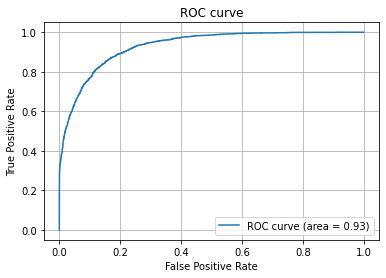

accuracy 0.871199557766722
precision 0.7966631908237748


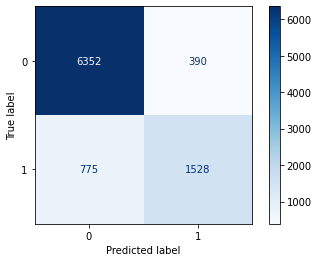

In [26]:
# AUCを計算
fpr, tpr, thresholds = roc_curve(np.asarray(y_test), y_pred)
print("AUC", auc(fpr, tpr))

# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' %auc(fpr, tpr))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

# accuracy, precisionを計算
acc = accuracy_score(np.asarray(y_test), np.round(y_pred))
precision = precision_score(np.asarray(y_test), np.round(y_pred))
print("accuracy", acc)
print("precision", precision)

# 混同行列をプロット
y_pred = np.round(y_pred)
cm = confusion_matrix(np.asarray(y_test), np.where(y_pred < 0.5, 0, 1))
cmp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
cmp.plot(cmap=plt.cm.Blues)
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

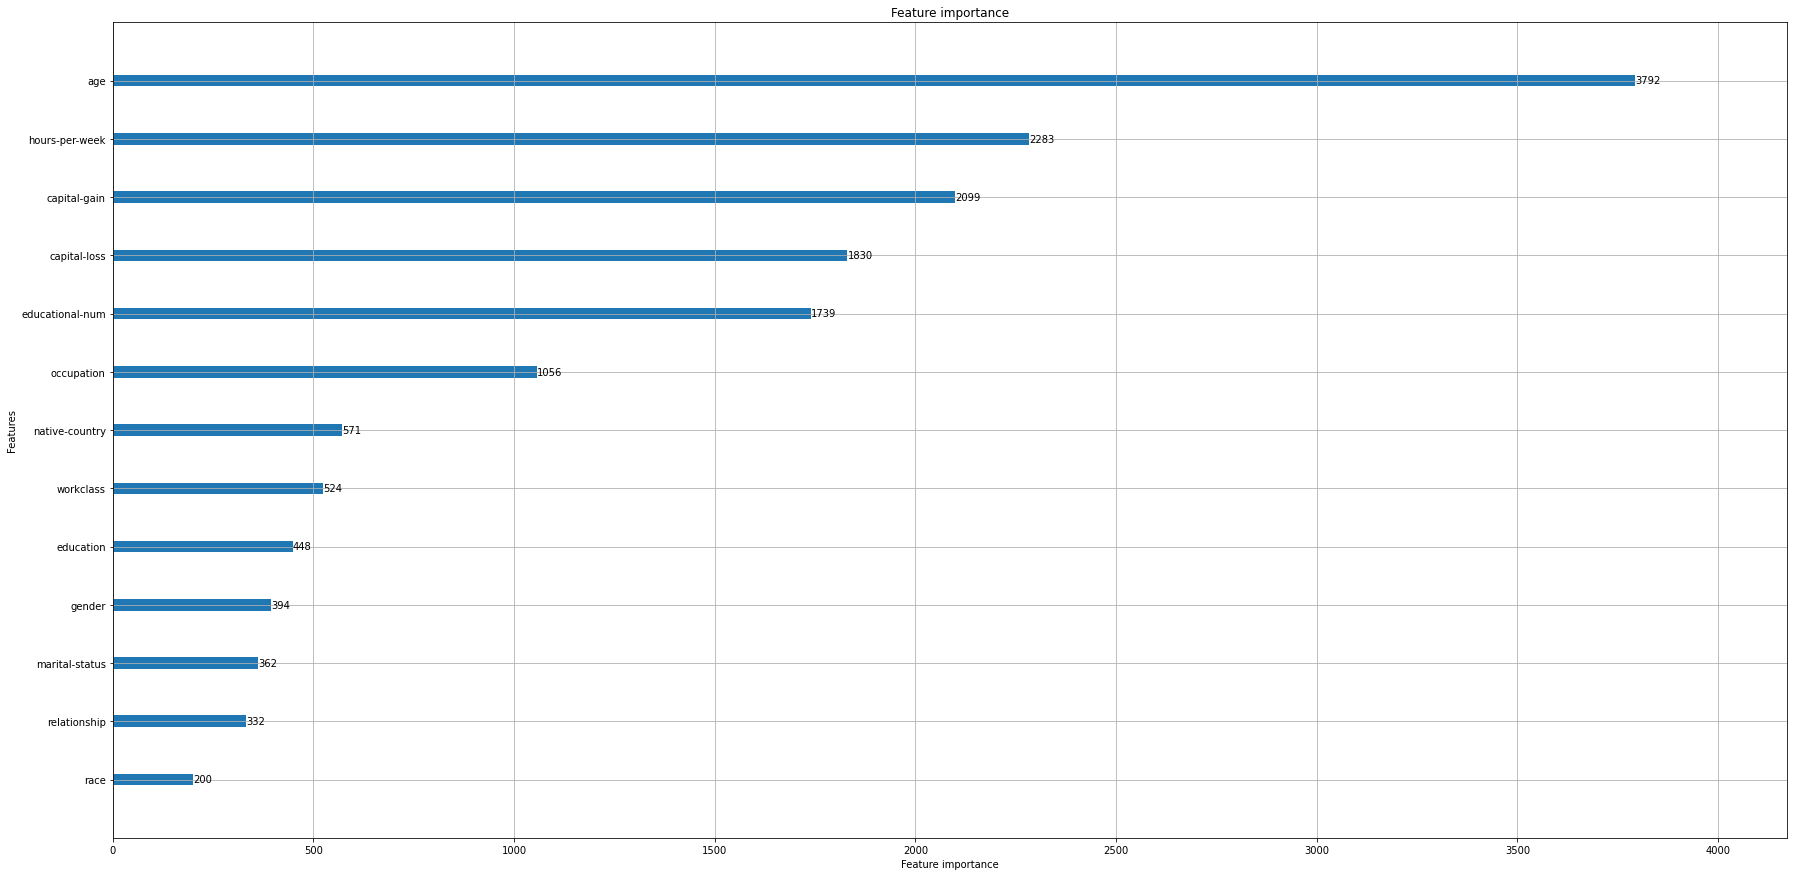

In [27]:
# 重要度としては「特徴量が分岐（ノード）の条件式で使用された回数」（＝デフォルト）
lgb.plot_importance(model, figsize=(30, 15), max_num_features=30, importance_type='split')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

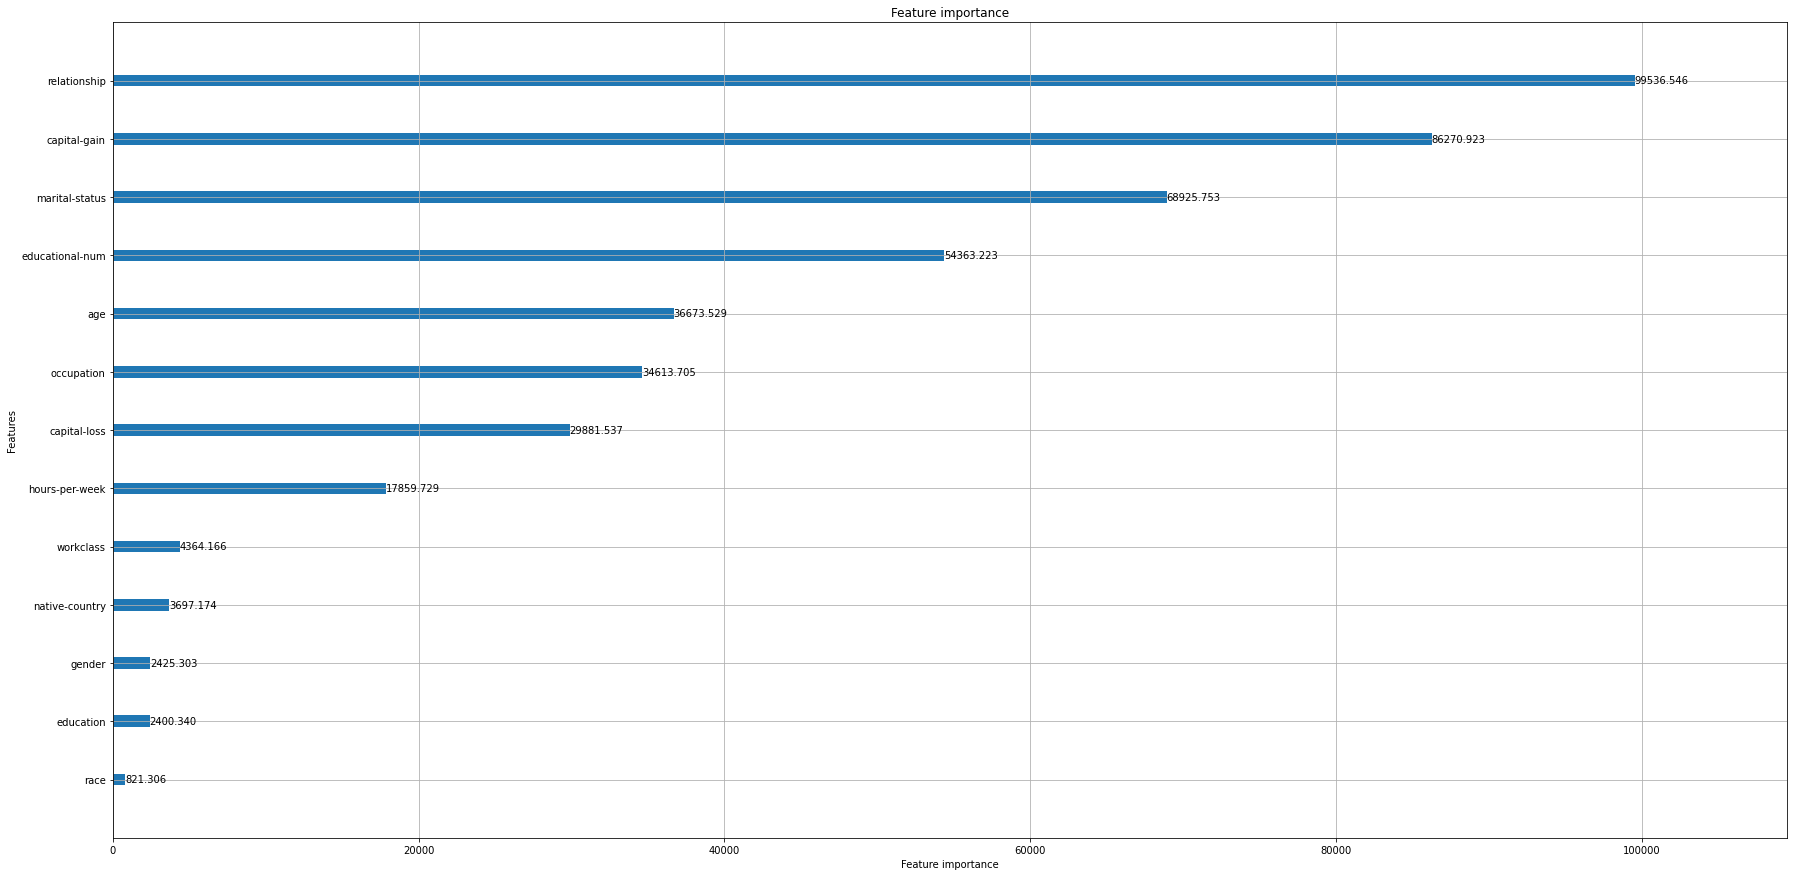

In [28]:
# 重要度としては「特徴量がある分岐（ノード）において目的関数の改善に寄与した度合い」
lgb.plot_importance(model, figsize=(30, 15), max_num_features=30, importance_type='gain')

In [29]:
# データフレームを綺麗に出力する関数
import IPython
def display(*dfs, head=True):
    for df in dfs:
        IPython.display.display(df.head() if head else df)

In [30]:
# 特徴量重要度を棒グラフでプロットする関数 
def plot_feature_importance(df): 
    n_features = len(df)                              # 特徴量数(説明変数の個数) 
    df_plot = df.sort_values('importance')            # df_importanceをプロット用に特徴量重要度を昇順ソート 
    f_importance_plot = df_plot['importance'].values  # 特徴量重要度の取得 
    plt.barh(range(n_features), f_importance_plot, align='center') 
    cols_plot = df_plot['feature'].values             # 特徴量の取得 
    plt.yticks(np.arange(n_features), cols_plot)      # x軸,y軸の値の設定
    plt.xlabel('Feature importance')                  # x軸のタイトル
    plt.ylabel('Feature')                             # y軸のタイトル

In [31]:
# 特徴量重要度の算出 (データフレームで取得)
cols = list(df.drop('income',axis=1).columns) # 特徴量名のリスト(目的変数target以外)
# 特徴量重要度の算出方法 'gain'(推奨) : トレーニングデータの損失の減少量を評価
f_importance = np.array(model.feature_importance(importance_type='gain')) # 特徴量重要度の算出 //
f_importance = f_importance / np.sum(f_importance) # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

,feature,importance
6,relationship,0.225281
9,capital-gain,0.195257
4,marital-status,0.155999
3,educational-num,0.123040
0,age,0.083003


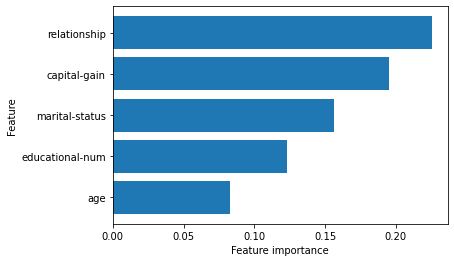

In [32]:
# 特徴量重要度の可視化
n_display = 5 # 上位10個に制限
plot_feature_importance(df_importance.iloc[:n_display,:])